## EDA & Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터셋 불러오기
df1 = pd.read_csv('data/2020-Jan.csv')
df2 = pd.read_csv('data/2020-Feb.csv')
df = pd.concat([df1,df2])
print(df.shape)
df.head

(8421434, 9)


<bound method NDFrame.head of                       event_time event_type  product_id          category_id  \
0        2020-01-01 00:00:00 UTC       view     5809910  1602943681873052386   
1        2020-01-01 00:00:09 UTC       view     5812943  1487580012121948301   
2        2020-01-01 00:00:19 UTC       view     5798924  1783999068867920626   
3        2020-01-01 00:00:24 UTC       view     5793052  1487580005754995573   
4        2020-01-01 00:00:25 UTC       view     5899926  2115334439910245200   
...                          ...        ...         ...                  ...   
4156677  2020-02-29 23:59:32 UTC       view     5885416  1487580005092295511   
4156678  2020-02-29 23:59:39 UTC       cart     5550686  1487580008145748965   
4156679  2020-02-29 23:59:45 UTC       view     5850628  1602943681873052386   
4156680  2020-02-29 23:59:54 UTC       view     5716351  1487580010872045658   
4156681  2020-02-29 23:59:59 UTC       view     5927709  1487580013950664926   

        c

In [3]:
# 이탈율
count = {}
lists = [i for i in df['user_session']]
for i in lists:
    try: count[i] += 1
    except: count[i] = 1

ans = [value for key, value in count.items() if value == 1]
len(ans)

bounce_rate = len(ans) / len(lists)
print(bounce_rate)


0.14614779383178683


In [4]:
bounce = [key for key, value in count.items() if value == 1]
b = pd.DataFrame({'user_session':bounce})
b = pd.merge(b, df[['user_session','event_type']], on='user_session', how='left')
b

,user_session,event_type
0,4adb70bb-edbd-4981-b60f-a05bfd32683a,view
1,c8c5205d-be43-4f1d-aa56-4828b8151c8a,view
2,cff70ddf-529e-4b0c-a4fc-f43a749c0acb,view
3,e04ed824-4857-40e4-a783-aca4001bc05b,view
4,2d7bf387-7c51-4a5f-bce8-c3bb0c9c2ab7,view
...,...,...
1230769,a859392f-9169-4f8a-b761-0e106f666259,view
1230770,062d2f70-2039-4e9d-8530-ec12874e8cf0,view
1230771,268c0dae-3755-469d-bc7c-8e56f37888d9,view
1230772,fd47f5cd-6ed1-43f1-a9c6-df6f0f72538a,view


In [5]:
b.groupby(['event_type']).count()

,user_session
event_type,
cart,25306
purchase,549
remove_from_cart,4036
view,1200883


In [6]:
# 데이터 타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8421434 entries, 0 to 4156681
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 642.5+ MB


In [7]:
# 데이터 결측치 확인
df.isnull().sum()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    8269530
brand            3601538
price                  0
user_id                0
user_session        2369
dtype: int64

In [8]:
# 데이터 규모
print(df.shape[0]) # 로그
print(df['user_id'].nunique()) # 사용자
print(df['product_id'].nunique()) # 제품
print(df[(df.event_type =='purchase')].shape[0]) # 구매

8421434
737093
50924
505790


In [9]:
# 특성 엔지니어링
def int_to_str(n):
    res = []
    for i in n:
        res.append(str(i))
    return res

def preprocess(df): 
    # 1) int to string
    df['product_id'] = int_to_str(df['product_id'])
    df['category_id'] = int_to_str(df['category_id'])
    df['user_id'] = int_to_str(df['user_id'])

    # 2) event_time type - obj to datetime
    df['datetime'] = df['event_time'].apply(lambda d: str(d)[0:19]) # UTC 제거
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # 3) 결측률 높은 특성 제거
    labels = df.isnull().mean()
    selected_features = labels[labels <= 0.5].index.tolist()
    df = df[selected_features]

    # 4) brand 컬럼 - 결측값 대체
    df['brand'] = df['brand'].replace(np.nan,'Not Available')

    # 5) user_session 컬럼 제거
    # 사용자의 임시 세션 ID로 장시간 사용 멈춤에서 온라인 쇼핑몰로 돌아올 때마다 변경되어, 분석 프로젝트에서 불필요하다고 판단
    df.drop(columns=['user_session'], inplace=True)

    # 6) 주문번호 컬럼 생성
    df['ordernumber'] = df['user_id'] + df['product_id'] + df['category_id']

    return df

data = preprocess(df)
data.shape

(8421434, 9)

,event_type,count
0,view,3991194
1,cart,2297017
2,remove_from_cart,1627433
3,purchase,505790


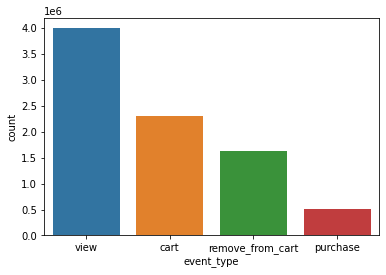

In [10]:
# 고객 행동 단계별 비율
customer_behavior = df['event_type'].value_counts().reset_index().rename(columns={'index':'event_type','event_type':'count'})
sns.barplot(data= customer_behavior, x= 'event_type', y= 'count');
customer_behavior

In [11]:
fig = px.funnel(customer_behavior, 
                x='count', 
                y='event_type')
fig.update_traces(texttemplate='%{x:.f}')
fig.show()

# HTML 내보내기
fig = go.Figure(data=fig)
fig.write_html('example_funnel.html')

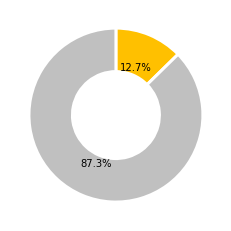

In [12]:
# 구매전환율
view_n_purchase = df['event_type'].value_counts()
purchase_conversion_rate = view_n_purchase['purchase'] / view_n_purchase['view']
purchase_conversion_rate

pie_df = pd.DataFrame({"ratio": [purchase_conversion_rate*100, 100-(purchase_conversion_rate*100)], "labels":['purchase_conversion_rate', '']})

# ratio = [purchase_conversion_rate*100, 100-(purchase_conversion_rate*100)]
# labels = ['purchase_conversion_rate', '']
# colors = ['#ffc000', '#c0c0c0']
# wedgeprops={'width': 0.5, 'edgecolor': 'w', 'linewidth': 3}

# plt.pie(ratio, autopct='%.1f%%', startangle=90, counterclock=False, colors=colors, wedgeprops=wedgeprops)
# plt.show()

In [13]:
# 시간대별 평균 구매 횟수
data_time = data[data['event_type'].isin(['purchase'])][['event_time','price']]
data_time = pd.DataFrame(data_time)
data_time['m'] = [i[5:7] for i in data_time['event_time']]
data_time['d'] = [i[8:10] for i in data_time['event_time']]
data_time['t'] = [i[11:13] for i in data_time['event_time']]
data_time

,event_time,price,m,d,t
60,2020-01-01 00:06:07 UTC,2.16,01,01,00
61,2020-01-01 00:06:07 UTC,7.92,01,01,00
590,2020-01-01 00:51:38 UTC,14.51,01,01,00
591,2020-01-01 00:52:00 UTC,19.37,01,01,00
593,2020-01-01 00:52:11 UTC,10.95,01,01,00
...,...,...,...,...,...
4156349,2020-02-29 23:46:01 UTC,49.21,02,29,23
4156563,2020-02-29 23:54:44 UTC,7.83,02,29,23
4156564,2020-02-29 23:54:44 UTC,0.32,02,29,23
4156565,2020-02-29 23:54:44 UTC,4.75,02,29,23


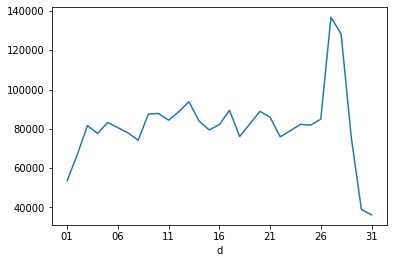

In [14]:
# 월별/일별/시간별 매출 합계
# data = data_time.groupby(['d'])['price'].sum().plot.line();
fig, ax = plt.subplots()
d_day = data_time.groupby(['d'])['price'].sum()
d_day.plot.line()

# 이미지 내보내기
fig.savefig('example_graph1.png')

# HTML 내보내기
fig = go.Figure(data=px.line(d_day))
fig.write_html('example_graph1.html', default_width = '100%' , default_height = '60%')

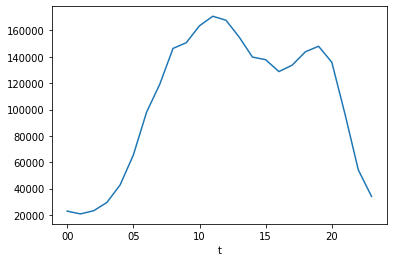

In [15]:
# 시간별 매출 합계
fig, ax = plt.subplots()
d_time = data_time.groupby(['t'])['price'].sum()
d_time.plot.line()

# 이미지 내보내기
fig.savefig('example_graph2.png')

# HTML 내보내기
fig = go.Figure(data=px.line(d_time))
fig.write_html('example_graph2.html')

In [16]:
# 특성 엔지니어링
def preprocess2(df): 
    # 1) crosstab
    dataset = pd.crosstab(index=[df.user_id, df.category_id, df.product_id], columns=df.event_type).reset_index()

    # 2) 주문번호 컬럼 생성
    dataset['ordernumber'] = dataset['user_id'] + dataset['product_id'] + dataset['category_id']

    # 3) 가격/구매시간 컬럼 추가
    price = data.groupby(['ordernumber'])['price'].last().reset_index(name = 'price')
    dataset = pd.merge(dataset, price, on='ordernumber', how='left')

    pur_time = data[(data['event_type']=='purchase')].groupby(['ordernumber'])['datetime'].last().reset_index(name = 'pur_time')
    dataset = pd.merge(dataset, pur_time, on='ordernumber', how='left')

    # 4) first_time, last_time 컬럼 생성
    # data.groupby(['ordernumber'])['datetime'].agg(np.min)
    first_time = data[(data['event_type']=='view')].groupby(['ordernumber'])['datetime'].first().reset_index(name = 'first_time')
    last_time = data[(data['event_type']=='view')].groupby(['ordernumber'])['datetime'].last().reset_index(name = 'last_time')

    dataset = pd.merge(dataset, first_time, on='ordernumber', how='left')
    dataset = pd.merge(dataset, last_time, on='ordernumber', how='left')

    # 5) purchase_status 컬럼 생성
    dataset['purchase_status'] = dataset['purchase_status'] = [1 if i >= 1 else 0 for i in dataset['purchase']]

    # 6) dif_time 컬럼 생성
    dataset['dif_time'] = (dataset['last_time'] - dataset['first_time']).dt.seconds / 60 
    dataset['dif_time'] = dataset['dif_time'].replace(np.nan, 0)

    # 7) Overfitting 방지
    dataset.drop(columns=['purchase','ordernumber'], inplace=True)

    return dataset

dataset = preprocess2(data)
dataset.shape

(4319996, 12)

In [17]:
dataset.to_csv('dataset.csv')

## ML Modeling

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import xgboost
from xgboost import XGBClassifier

In [19]:
dataset = pd.read_csv('dataset.csv')
dataset = dataset.drop(['Unnamed: 0'], axis=1)

dataset['pur_time'] = pd.to_datetime(dataset['first_time']).map(dt.datetime.toordinal)
dataset['first_time'] = pd.to_datetime(dataset['first_time']).map(dt.datetime.toordinal)
dataset['last_time'] = pd.to_datetime(dataset['last_time']).map(dt.datetime.toordinal)

print(dataset.shape)
dataset.head

In [20]:
# target baseline
target = 'purchase_status'
features = dataset.drop(columns=[target]).columns
X_train = dataset[features]
y_train = dataset[target]

major = y_train.mode()[0]
y_pred = [major]*len(y_train)

print('기준 모델 정확도: {0:.4f}'.format(accuracy_score(y_train, y_pred)))

# target 비율
dataset[target].value_counts(normalize=True) # 데이터 불균형

In [21]:
# 훈련/테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [22]:
# 1) XGB Classifier
model = XGBClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: ', f1_score(y_test, predictions))

In [23]:
# GridSearchCV를 사용한 하이퍼파라미터 튜닝
grids = {
    'xgbclassifier__learning_rate': [0.01, 0.1],
    'xgbclassifier__max_depth': [3,5,7,9,10],
    'xgbclassifier__scale_pos_weight': [1,99]
    }

xgb_grid = GridSearchCV(
        model,
        param_grid=grids,
        cv=3,
        scoring='f1',
        verbose=1,
        n_jobs=-1
        )

xgb_grid.fit(X_train, y_train);
print(xgb_grid.best_params_)

best1 = xgb_grid.best_estimator_
pred1 = best1.predict(X_test)

accuracy = accuracy_score(y_test, pred1)
print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: ', f1_score(y_test, pred1))

In [24]:
# 2) Random Forest Classifier
model2 = RandomForestClassifier()
model2.fit(X_train, y_train)

predictions = model2.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: ', f1_score(y_test, predictions))

In [25]:
# 3) Decision Tree Classifier
model3 = DecisionTreeClassifier(max_depth=5, random_state=2)
model3.fit(X_train, y_train)

predictions = model3.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: ', f1_score(y_test, predictions))

In [26]:
# GridSearchCV를 사용한 하이퍼파라미터 튜닝
param={"min_samples_leaf":[1, 3, 5, 7, 9],
       "max_depth":[3, 4, 5, None],
       "min_samples_split":[2, 3, 4, 5]}
df = DecisionTreeClassifier()
gs = GridSearchCV(df, param_grid=param, cv=3)
gs.fit(X_train, y_train)

best2 = gs.best_estimator_
pred2 = best.predict(X_test)

accuracy = accuracy_score(y_test, pred2)
print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: ', f1_score(y_test, pred2))